In [34]:
import langchain
print(langchain.__version__)

0.3.4


In [35]:
import os
import streamlit as st
from typing import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import END, StateGraph
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig
from pydantic import BaseModel, Field, model_validator  # model_validator 임포트
import random

# Define the GraphState class
class GraphState(TypedDict):
    question: str  # 질문
    state: str  # categorized의 결과
    answer: str  # Query만

# Initialize the LLM
llm = ChatOpenAI(
    temperature=0.0,
    max_tokens=300,
    model="gpt-4o-mini",
    api_key=os.environ.get("OPENAI_API_KEY")
)

class Categorized(BaseModel):
    common_conversation: bool = Field(
        description="""사용자가 일반적인 대화를 원하면 True, 그렇지 않으면 False를 대답해줘"""
    )
    SQLQuery: bool = Field(
        description="""사용자가 쿼리문을 요청하거나, 데이터에 대한 정보를 원하면 True, 그렇지 않으면 False를 대답해줘."""
    )

    @model_validator(mode="after")
    def check_only_one_true(cls, values):
        # 객체 속성 접근 방식 사용
        if values.common_conversation == values.SQLQuery:  # 둘 다 True 또는 둘 다 False인 경우 에러 발생
            raise ValueError("common_conversation과 SQLQuery 중 하나만 True여야 합니다.")
        return values

# Define the behavior_Classification function to check relevance and set the branching condition in "answer"
def behavior_Classification(state: GraphState) -> GraphState:
    # Set up the structured LLM output to use the Categorized schema
    structured_llm = llm.with_structured_output(Categorized)
    response = structured_llm.invoke(state["question"])
    
    # Determine which field is True and use that as the answer
    if response.common_conversation:
        state["state"] = "common_conversation"
    elif response.SQLQuery:
        state["state"] = "SQLQuery"
    
    return state

# Define the llm_answer function to get an answer from the LLM
def common_answer(state: GraphState) -> GraphState:
    state["answer"] = llm.invoke(state["question"])
    return state

def is_valid_sql_query_text(state: GraphState) -> GraphState:
    state["answer"] = llm.invoke(state["question"])
    # 1/2 확률로 True 또는 False 설정
    state["answer"] = "True" if random.choice([True, False]) else "False"
    return state

def transfer_TextToSQL(state: GraphState) -> GraphState:
    # 프롬프트 템플릿 정의
    template = """질문: {question}

    주의사항: 아래의 답변은 SQL 쿼리문으로만 작성됩니다. 다른 설명이나 답변 없이 SQL 쿼리문만 생성해 주세요.

    SQL 답변: """
    prompt = ChatPromptTemplate.from_template(template)
    model = ChatOpenAI(
        temperature=0.0,
        max_tokens=300,
        model="gpt-4o-mini",
        api_key=os.environ.get("OPENAI_API_KEY")
    )
    # LLM Chain 객체 생성
    chain = prompt | model | StrOutputParser()
    state["answer"] = chain.invoke({"question": state["question"]})
    return state

# Define the rewrite function to improve the question prompt
def rewrite_question(state: GraphState) -> GraphState:
    question = state["question"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an assistant to enhance questions related to customer requirements for data analysis and advertising. "
                "The task involves improving questions based on the following customer objectives and data requirements."
            ),
            (
                "human",
                """
                Here are the key customer requirements:\n"
                "- **Channel Analysis**:\n"
                "  - Step 1: Identifying donation amount, count, and source traffic (Understand data types and relationships)\n"
                "  - Step 2: Budget planning for ads, understanding media offerings (exposure, click-through rate), and conversion to donations.\n"
                "- **Landing Page Analysis**\n"
                "- **Dataset Availability**:\n"
                "  - Planned statistics for all customer data, implementation time constraints.\n"
                "  - Risks include small sample size, possible unintended exposure.\n\n"
                "Given these, the initial question was:\n ------- \n{question}\n ------- \n"
                "Can you revise this question to better align with the customer’s analysis objectives?"
                Please be sure to answer the question, and only answer the question Korean.
                """
            ),
        ]
    )

    model = ChatOpenAI(
        temperature=0.0,
        max_tokens=300,
        model="gpt-4o-mini",
        api_key=os.environ.get("OPENAI_API_KEY")
    )

    chain = prompt | model | StrOutputParser()
    response = chain.invoke({"question": question})
    return GraphState(question=response, answer=state["answer"])

In [42]:
from langgraph.graph import END, StateGraph

    # Define the workflow
workflow = StateGraph(GraphState)

# Add nodes to the workflow
workflow.add_node("categorized", behavior_Classification)
workflow.add_node("common", common_answer)
workflow.add_node("is_valid_sql_query_text", is_valid_sql_query_text)
workflow.add_node("rewrite_question", rewrite_question)
workflow.add_node("transfer_TextToSQL", transfer_TextToSQL)

# Add conditional edges for the categorized node
workflow.add_conditional_edges(
        "categorized",
        lambda state: state["state"],  # Use the "answer" key to determine branching
        {
            "common_conversation": "common",
            "SQLQuery": "is_valid_sql_query_text",
        },
    )

# Add conditional edges for the TextToSQL node to handle query-related responses
workflow.add_conditional_edges(
        "is_valid_sql_query_text",
        lambda state: state["answer"],
        {
            "True": "transfer_TextToSQL",
            "False": "rewrite_question"
        },
    )
workflow.add_edge("rewrite_question", "is_valid_sql_query_text")
workflow.add_edge("transfer_TextToSQL", END)

# Set entry point
workflow.set_entry_point("categorized")

# Compile the workflow
app = workflow.compile()

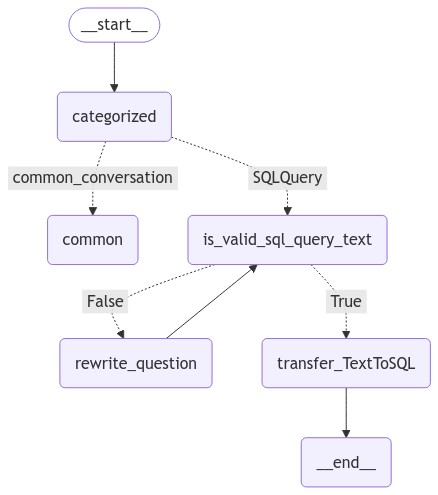

In [43]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [49]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10, configurable={"thread_id": "CORRECTIVE-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question="10월 31일 youtube/video 방문자수."
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

"Output from node 'categorized':"
'---'
{'question': '10월 31일 youtube/video 방문자수.', 'state': 'SQLQuery'}
'\n---\n'
"Output from node 'is_valid_sql_query_text':"
'---'
{ 'answer': 'False',
  'question': '10월 31일 youtube/video 방문자수.',
  'state': 'SQLQuery'}
'\n---\n'
"Output from node 'rewrite_question':"
'---'
{ 'answer': 'False',
  'question': '고객의 분석 목표에 더 잘 맞도록 질문을 다음과 같이 수정할 수 있습니다:\n'
              '\n'
              '"10월 31일에 YouTube 비디오에서 발생한 방문자 수와 해당 방문자들의 기부 금액 및 기부 횟수는 '
              '얼마입니까?"'}
'\n---\n'
"Output from node 'is_valid_sql_query_text':"
'---'
{ 'answer': 'True',
  'question': '고객의 분석 목표에 더 잘 맞도록 질문을 다음과 같이 수정할 수 있습니다:\n'
              '\n'
              '"10월 31일에 YouTube 비디오에서 발생한 방문자 수와 해당 방문자들의 기부 금액 및 기부 횟수는 '
              '얼마입니까?"',
  'state': 'SQLQuery'}
'\n---\n'
"Output from node 'transfer_TextToSQL':"
'---'
{ 'answer': '```sql\n'
            'SELECT \n'
            '    COUNT(visitor_id) AS visitor_count,\n'
            '    SUM(donation_amount) AS to